In [2]:
# Chunk 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import os

# Workaround for SSL certificate issues
ssl._create_default_https_context = ssl._create_unverified_context

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Chunk 2: Network Architecture
class FlexibleActivationNetwork(nn.Module):
    def __init__(self, activation_functions):
        """
        Create a flexible neural network with configurable activation functions.
        
        :param activation_functions: List of activation functions for each layer
        """
        super(FlexibleActivationNetwork, self).__init__()
        
        # Activation function mapping
        self.activation_map = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(),
            'softmax': nn.Softmax(dim=1)
        }
        
        # Validate and convert activation functions
        self.activations = [self.activation_map.get(act.lower(), nn.ReLU()) for act in activation_functions]
        
        # Network layers
        self.layers = nn.ModuleList([
            nn.Linear(784, 256),   # Input layer
            nn.Linear(256, 128),   # Hidden layer 1
            nn.Linear(128, 64),    # Hidden layer 2
            nn.Linear(64, 10)      # Output layer
        ])
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            # Apply activation function except for the last layer
            x = self.activations[i](x)
        
        # Final layer without activation
        x = self.layers[-1](x)
        return x

In [4]:
# Chunk 3: Data Preparation
def prepare_data(download=True):
    """
    Prepare MNIST dataset for training and testing.
    
    :param download: Whether to download the dataset if not present
    :return: Train and test data loaders
    """
    # Ensure data directory exists
    os.makedirs('./data', exist_ok=True)
    
    # MNIST Data Transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    try:
        # Load MNIST Dataset
        train_dataset = datasets.MNIST(root='./data', train=True, download=download, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=download, transform=transform)
        
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        return train_loader, test_loader
    
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Please manually download the MNIST dataset or check your internet connection.")
        return None, None

In [5]:
# Chunk 4: Training Function
def train_network(activation_functions, learning_rate=0.01, epochs=10):
    """
    Train neural network with specified activation functions.
    
    :param activation_functions: List of activation functions
    :param learning_rate: Learning rate for optimizer
    :param epochs: Number of training epochs
    :return: Dictionary of training metrics
    """
    # Prepare data
    train_loader, test_loader = prepare_data()
    
    if train_loader is None or test_loader is None:
        print("Failed to load data. Skipping training.")
        return {}
    
    # Initialize network and optimizer
    model = FlexibleActivationNetwork(activation_functions)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    train_losses = []
    batch_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_losses.append(loss.item())
        
        # Average epoch loss
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%")
    
    return {
        'train_losses': train_losses,
        'batch_losses': batch_losses,
        'test_accuracies': test_accuracies
    }

In [6]:
# Chunk 5: Visualization Function
def visualize_results(results):
    """
    Create comprehensive visualizations for experiment results.
    
    :param results: Dictionary of experiment results
    """
    if not results:
        print("No results to visualize.")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Epoch-level Losses
    plt.subplot(2, 2, 1)
    for name, result in results.items():
        plt.plot(result['train_losses'], label=name)
    plt.title('Epoch-level Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Test Accuracies
    plt.subplot(2, 2, 2)
    for name, result in results.items():
        plt.plot(result['test_accuracies'], label=name)
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Batch-level Loss Distribution
    plt.subplot(2, 2, 3)
    for name, result in results.items():
        plt.hist(result['batch_losses'], bins=50, alpha=0.5, label=name)
    plt.title('Batch Loss Distribution')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Cumulative Batch Losses
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        cumulative_loss = np.cumsum(result['batch_losses'])
        plt.plot(cumulative_loss, label=name)
    plt.title('Cumulative Batch Losses')
    plt.xlabel('Batch Iterations')
    plt.ylabel('Cumulative Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Experiment 1: relu -> sigmoid -> tanh -> softmax


100.0%
100.0%
100.0%
100.0%


Epoch 1: Loss = 0.3146, Test Accuracy = 91.02%
Epoch 2: Loss = 0.2416, Test Accuracy = 91.96%
Epoch 3: Loss = 0.2740, Test Accuracy = 90.76%
Epoch 4: Loss = 0.2528, Test Accuracy = 91.60%
Epoch 5: Loss = 0.2546, Test Accuracy = 92.90%
Epoch 6: Loss = 0.2616, Test Accuracy = 93.25%
Epoch 7: Loss = 0.2553, Test Accuracy = 92.95%
Epoch 8: Loss = 0.2530, Test Accuracy = 90.98%
Epoch 9: Loss = 0.2471, Test Accuracy = 93.83%
Epoch 10: Loss = 0.2565, Test Accuracy = 91.79%

Experiment 2: relu -> relu -> relu -> softmax
Epoch 1: Loss = 0.3106, Test Accuracy = 93.23%
Epoch 2: Loss = 0.2024, Test Accuracy = 95.10%
Epoch 3: Loss = 0.1840, Test Accuracy = 94.80%
Epoch 4: Loss = 0.1565, Test Accuracy = 95.94%
Epoch 5: Loss = 0.1555, Test Accuracy = 96.04%
Epoch 6: Loss = 0.1463, Test Accuracy = 96.18%
Epoch 7: Loss = 0.1380, Test Accuracy = 95.90%
Epoch 8: Loss = 0.1272, Test Accuracy = 96.27%
Epoch 9: Loss = 0.1366, Test Accuracy = 96.14%
Epoch 10: Loss = 0.1300, Test Accuracy = 96.30%

Experiment

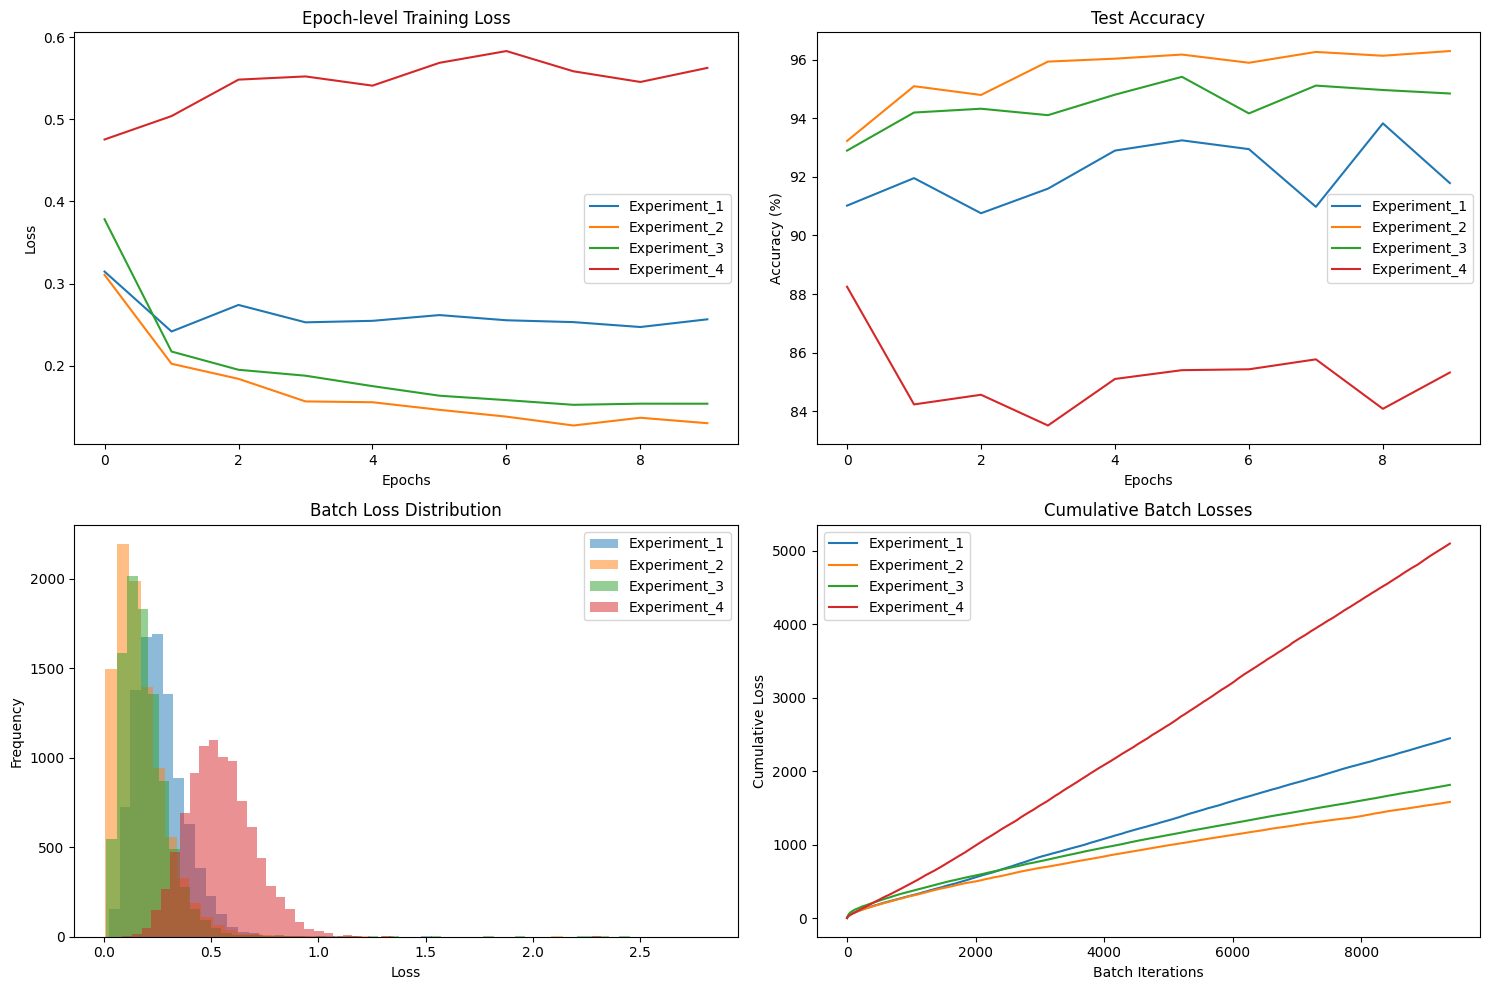

In [7]:
# Chunk 6: Experiment Runner
# Experiment with different activation functions
activation_combinations = [
    ['relu', 'sigmoid', 'tanh', 'softmax'],  # Mixed activations
    ['relu', 'relu', 'relu', 'softmax'],     # All ReLU
    ['sigmoid', 'sigmoid', 'sigmoid', 'softmax'],  # All Sigmoid
    ['tanh', 'tanh', 'tanh', 'softmax']      # All Tanh
]

# Run experiments
results = {}
for i, activations in enumerate(activation_combinations, 1):
    print(f"\nExperiment {i}: {' -> '.join(activations)}")
    exp_results = train_network(activations)
    if exp_results:  # Only add non-empty results
        results[f'Experiment_{i}'] = exp_results

# Visualize results if any experiments succeeded
if results:
    visualize_results(results)
else:
    print("No successful experiments to visualize.")